In [22]:
import pathlib
import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ALLCools.clustering import ConsensusClustering, Dendrogram, get_pc_centers
from ALLCools.plot import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [23]:
## Parameters

# input data
data_dir='/datasets/CZI_human_diversity/NOVAseq_hisat/'
CZIOI='CZIall'
cell_meta_path = '/datasets/CZI_human_diversity/NOVAseq_hisat/CZIall_CellMetadata.PassQC.csv.gz'
adata_path = f'{data_dir}{CZIOI}.chrom100k-clustering_CEF.h5ad'
coord_base = 'umap'

# ConsensusClustering
# Important factores
n_neighbors = 25
leiden_resolution = 1
# this parameter is the final target that limit the total number of clusters
# Higher accuracy means more conservative clustering results and less number of clusters
target_accuracy = 0.96 
min_cluster_size = 15

# Other ConsensusClustering parameters
metric = 'euclidean'
consensus_rate = 0.7
leiden_repeats = 500
random_state = 0
train_frac = 0.5
train_max_n = 500
max_iter = 100
n_jobs = 20

# Dendrogram via Multiscale Bootstrap Resampling
nboot = 10000
method_dist = 'correlation'
method_hclust = 'average'

plot_type = 'static'

# clustering name
clustering_name = 'cc_'+str(leiden_resolution)+'_'+str(target_accuracy)

In [24]:
# # load data
cell_meta = pd.read_csv(cell_meta_path, index_col=0)
adata = ad.read_h5ad(adata_path)

In [25]:
# Consensus Clustering
cc = ConsensusClustering(model=None,
                         n_neighbors=n_neighbors,
                         metric=metric,
                         min_cluster_size=min_cluster_size,
                         leiden_repeats=leiden_repeats,
                         leiden_resolution=leiden_resolution,
                         consensus_rate=consensus_rate,
                         random_state=random_state,
                         train_frac=train_frac,
                         train_max_n=train_max_n,
                         max_iter=max_iter,
                         n_jobs=n_jobs,
                         target_accuracy=target_accuracy)

Computing nearest neighbor graph
Computing multiple clustering with different random seeds
Repeating leiden clustering 500 times
Found 30 - 35 clusters, mean 32.7, std 1.00
Summarizing multiple clustering results
55178 cells assigned to 56 raw clusters
269 cells are multi-leiden outliers

=== Start supervise model training and cluster merging ===

=== iteration 1 ===
56 non-outlier labels
Balanced accuracy on the training set: 0.896
Balanced accuracy on the hold-out set: 0.857
Merging 3 clusters.

=== iteration 2 ===
53 non-outlier labels
Balanced accuracy on the training set: 0.908
Balanced accuracy on the hold-out set: 0.867
Merging 3 clusters.

=== iteration 3 ===
50 non-outlier labels
Balanced accuracy on the training set: 0.920
Balanced accuracy on the hold-out set: 0.895
Merging 3 clusters.

=== iteration 4 ===
47 non-outlier labels
Balanced accuracy on the training set: 0.937
Balanced accuracy on the hold-out set: 0.911
Merging 5 clusters.

=== iteration 5 ===
42 non-outlier lab

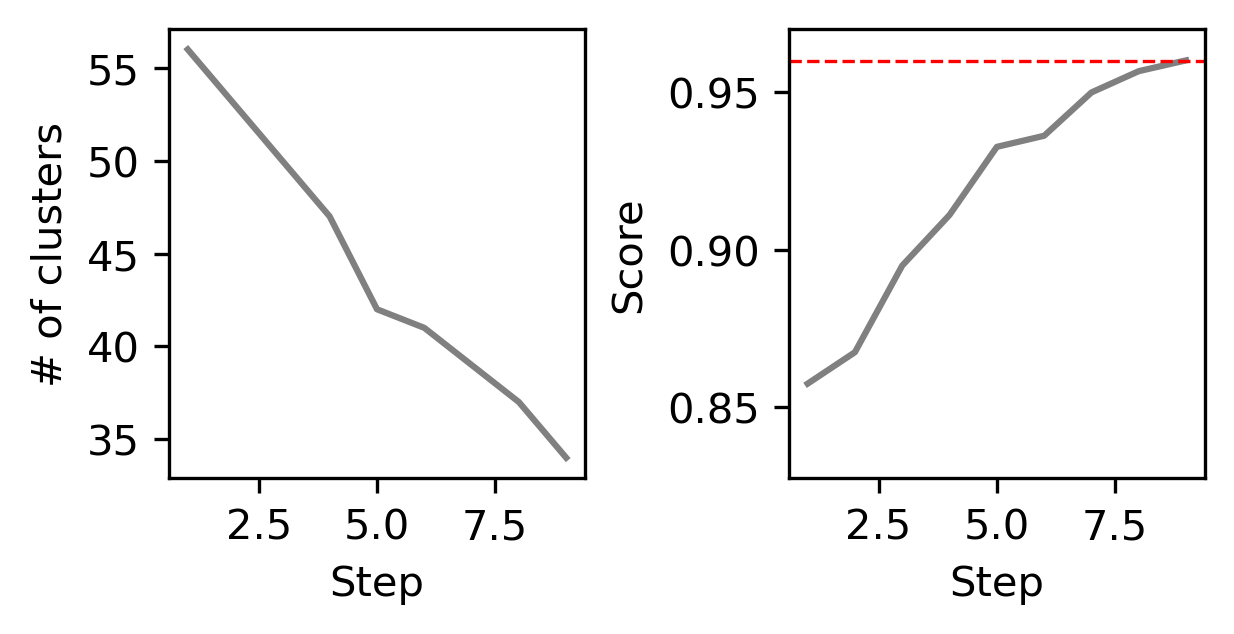

In [26]:
if 'X_pca' not in adata.obsm:
    raise KeyError(
        'X_pca do not exist in the adata file, run PCA first before clustering.'
    )
cc.fit_predict(adata.obsm['X_pca'])
cc.plot_merge_process(plot_size=2)
adata.obs[clustering_name] = cc.label

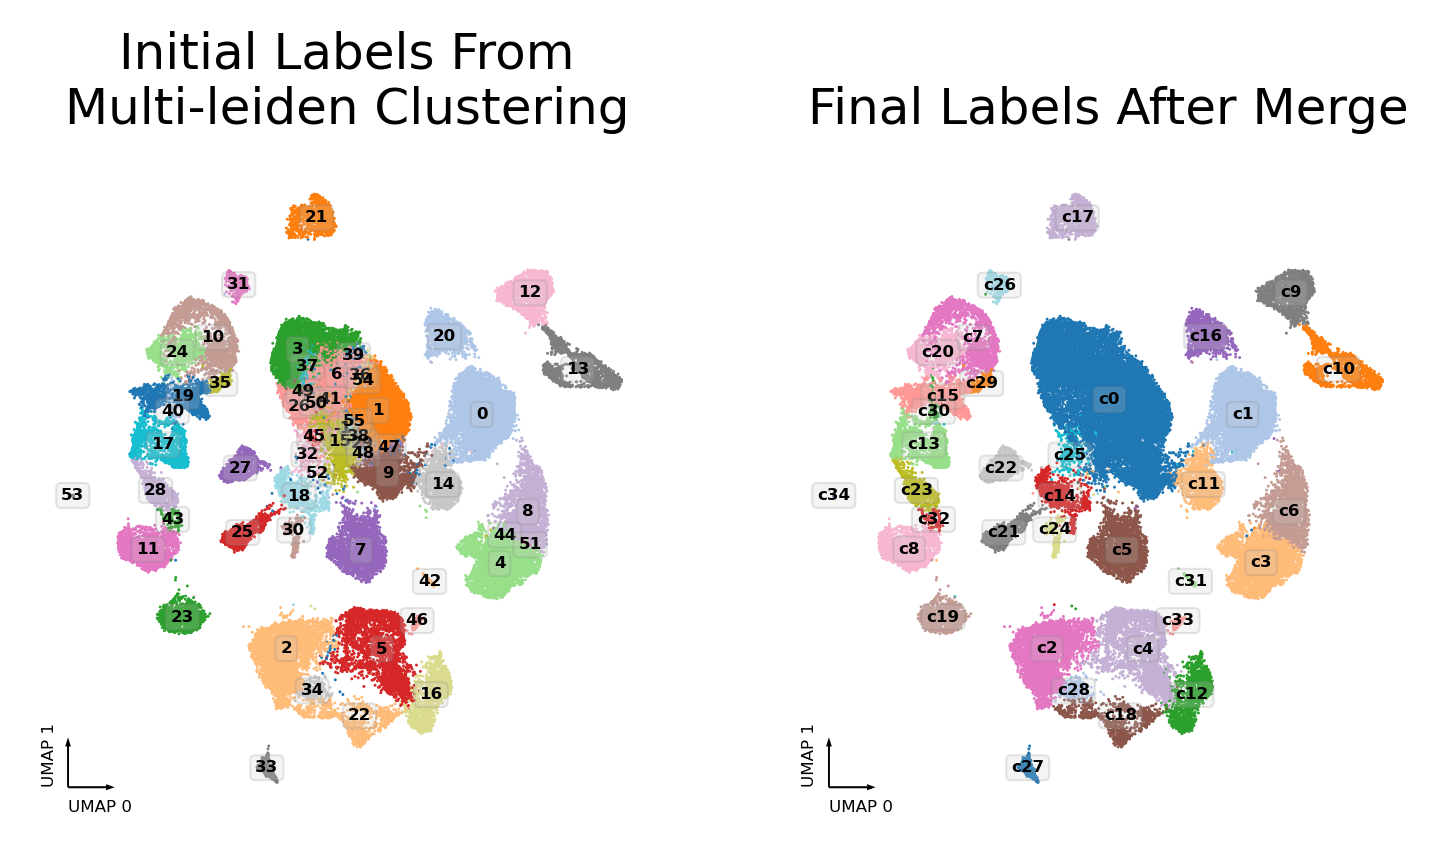

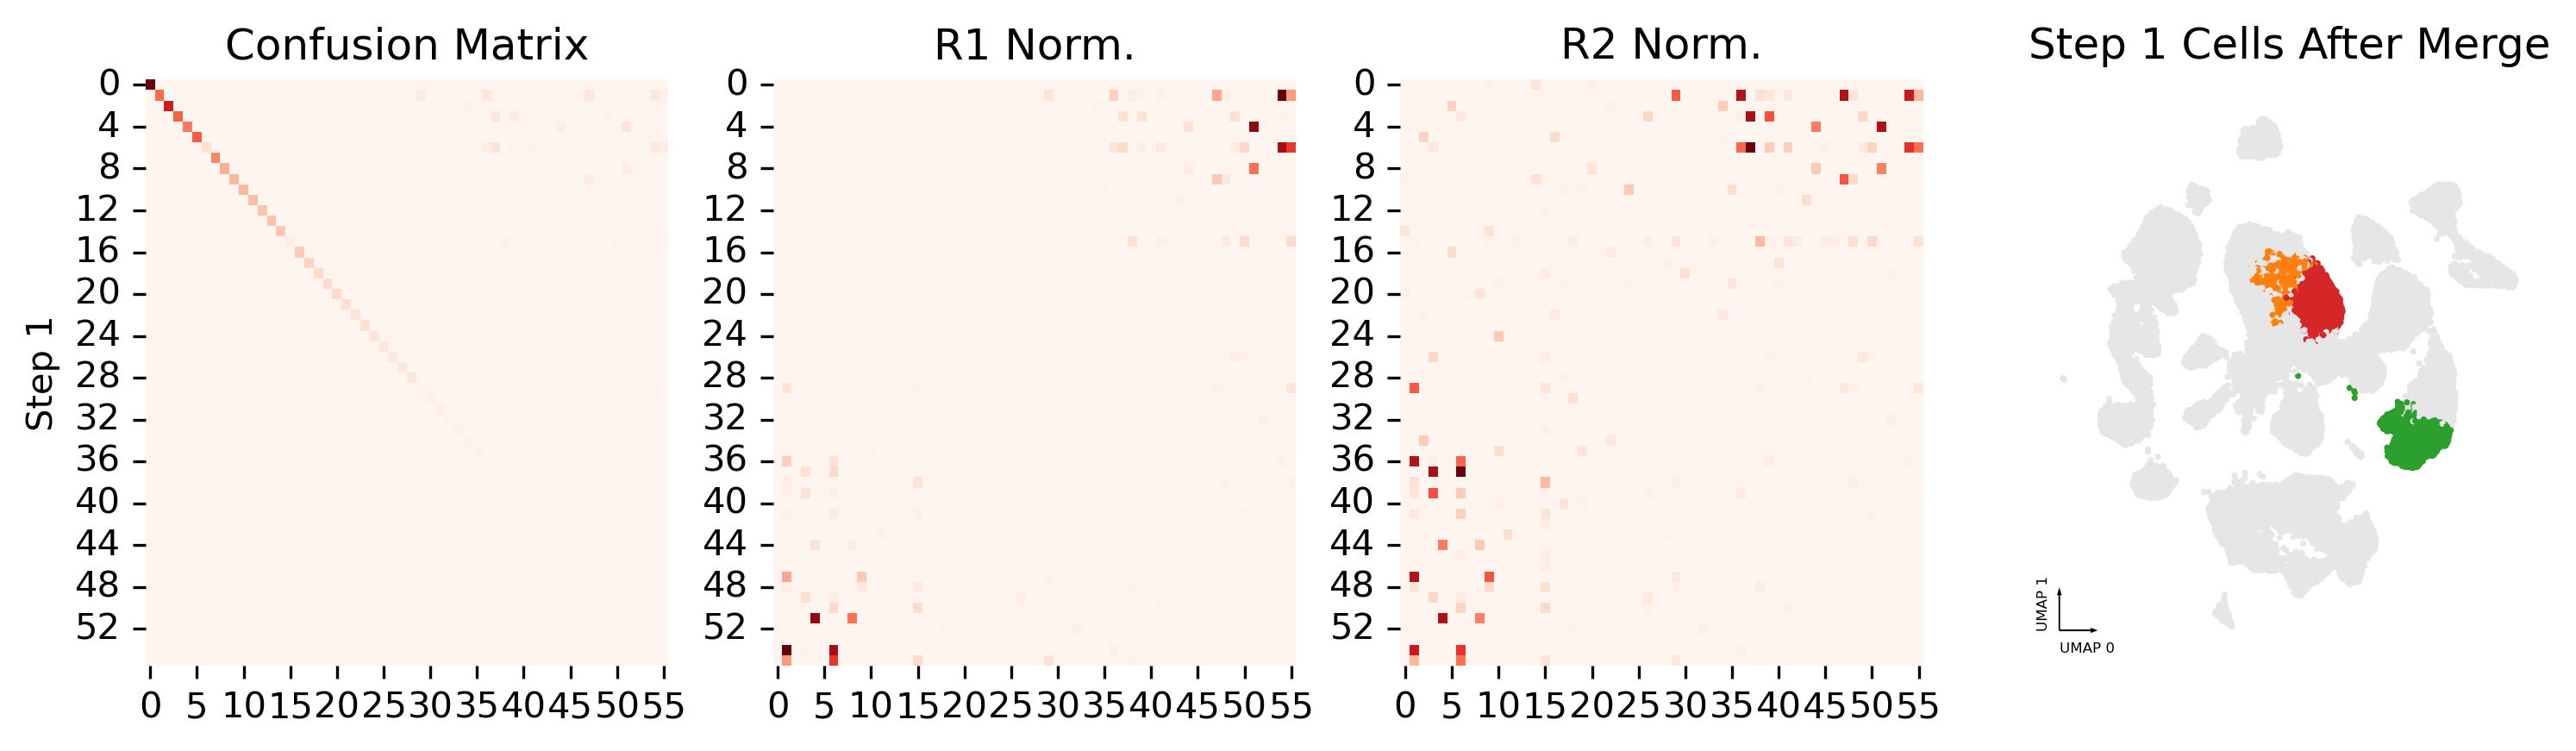

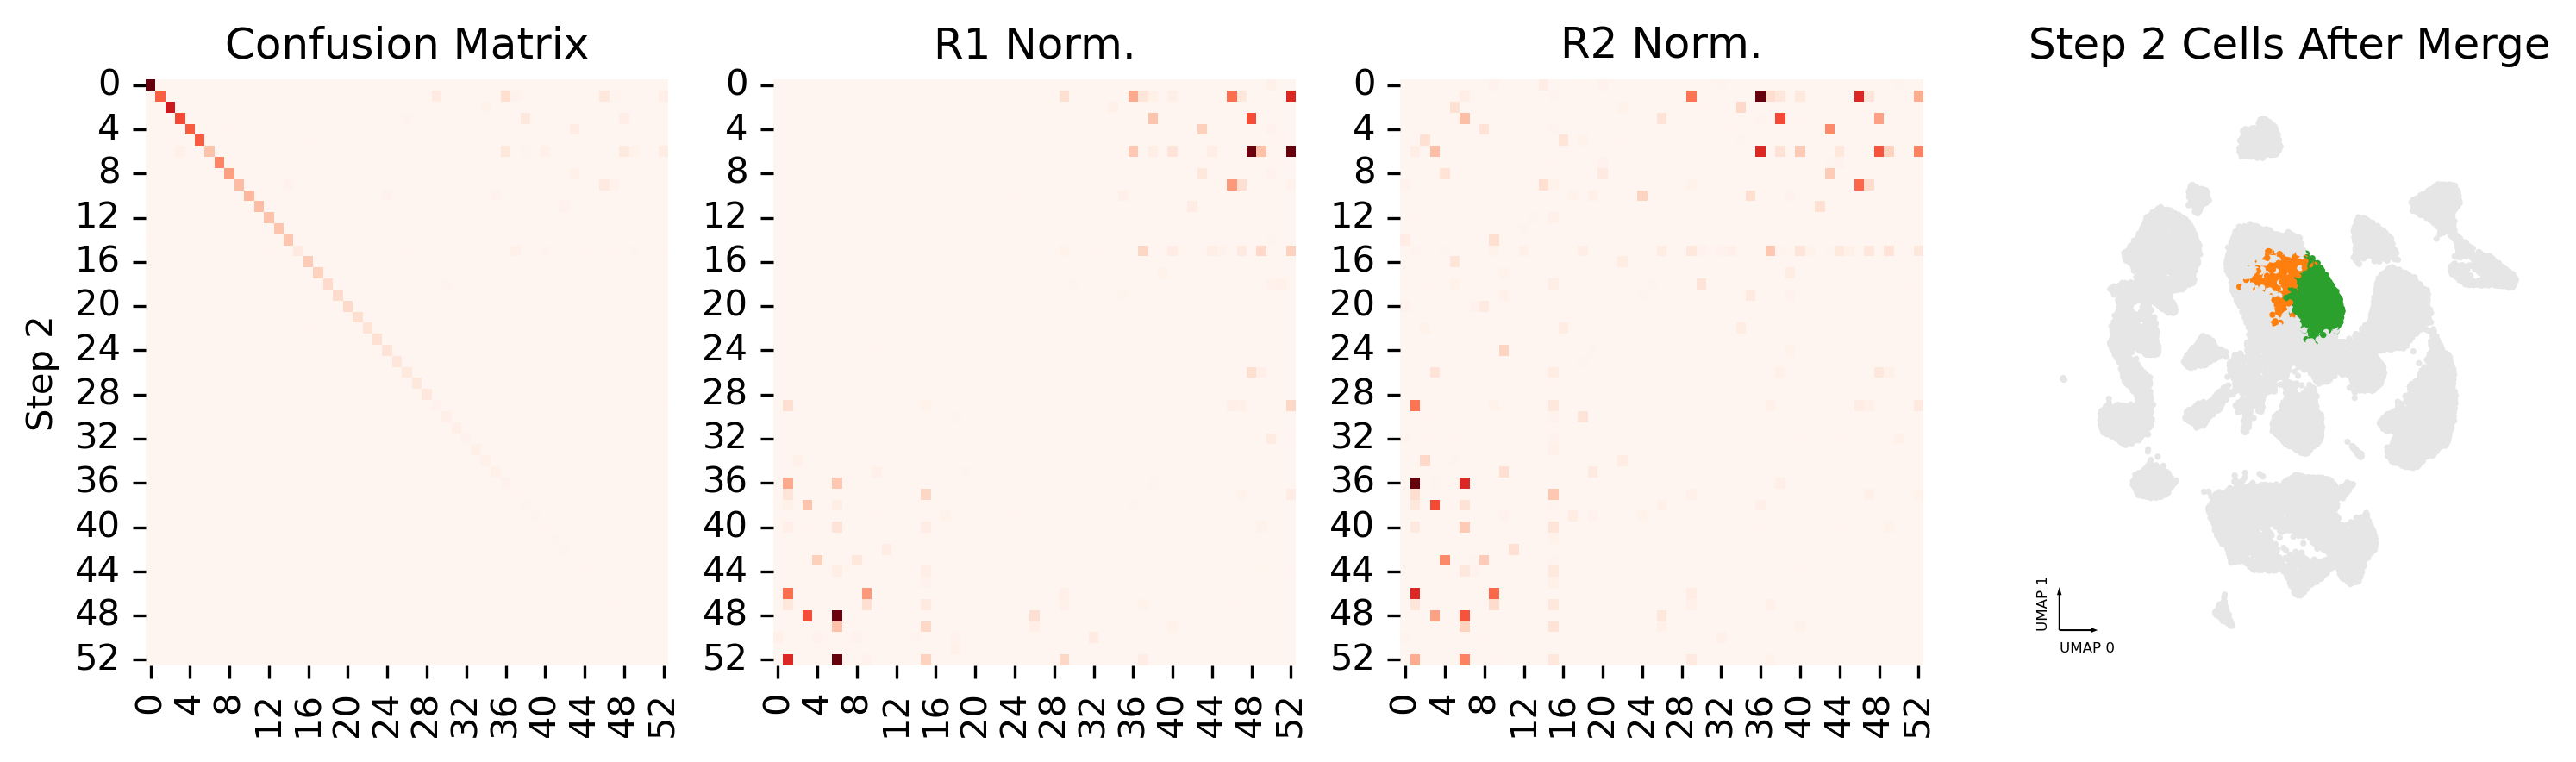

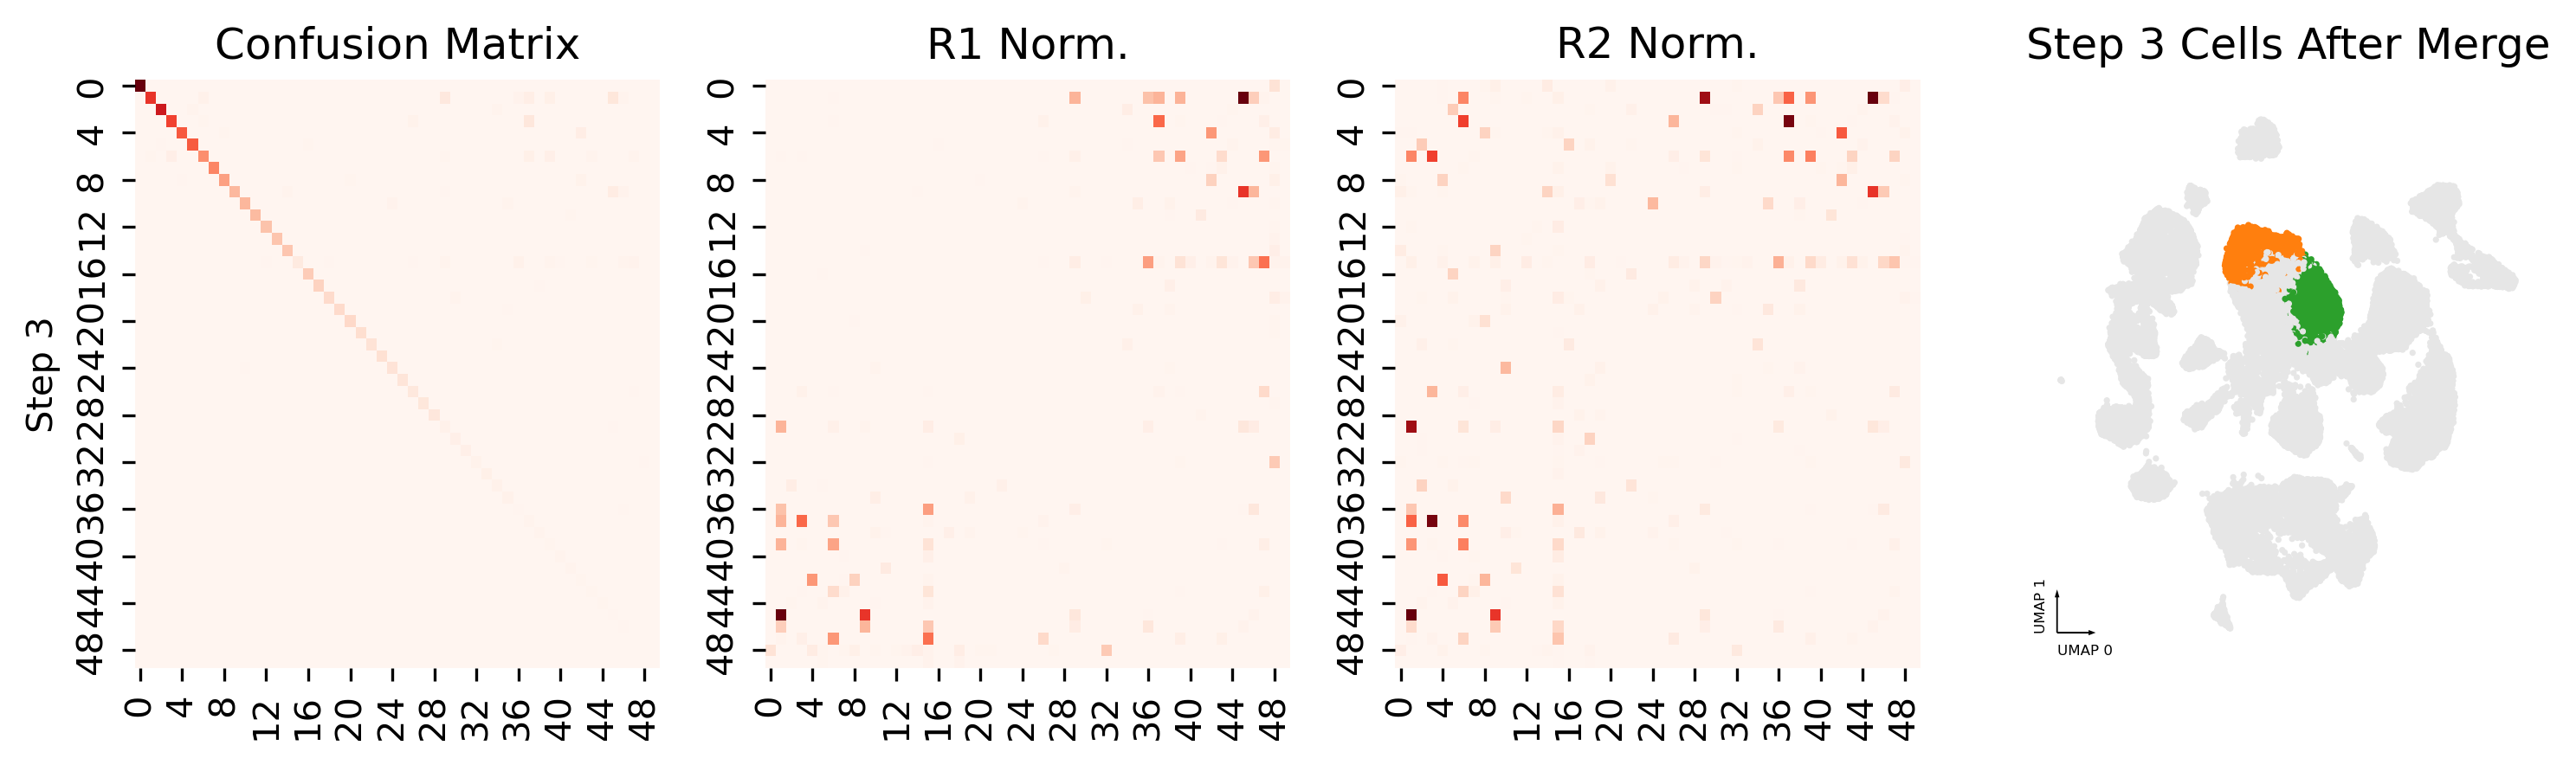

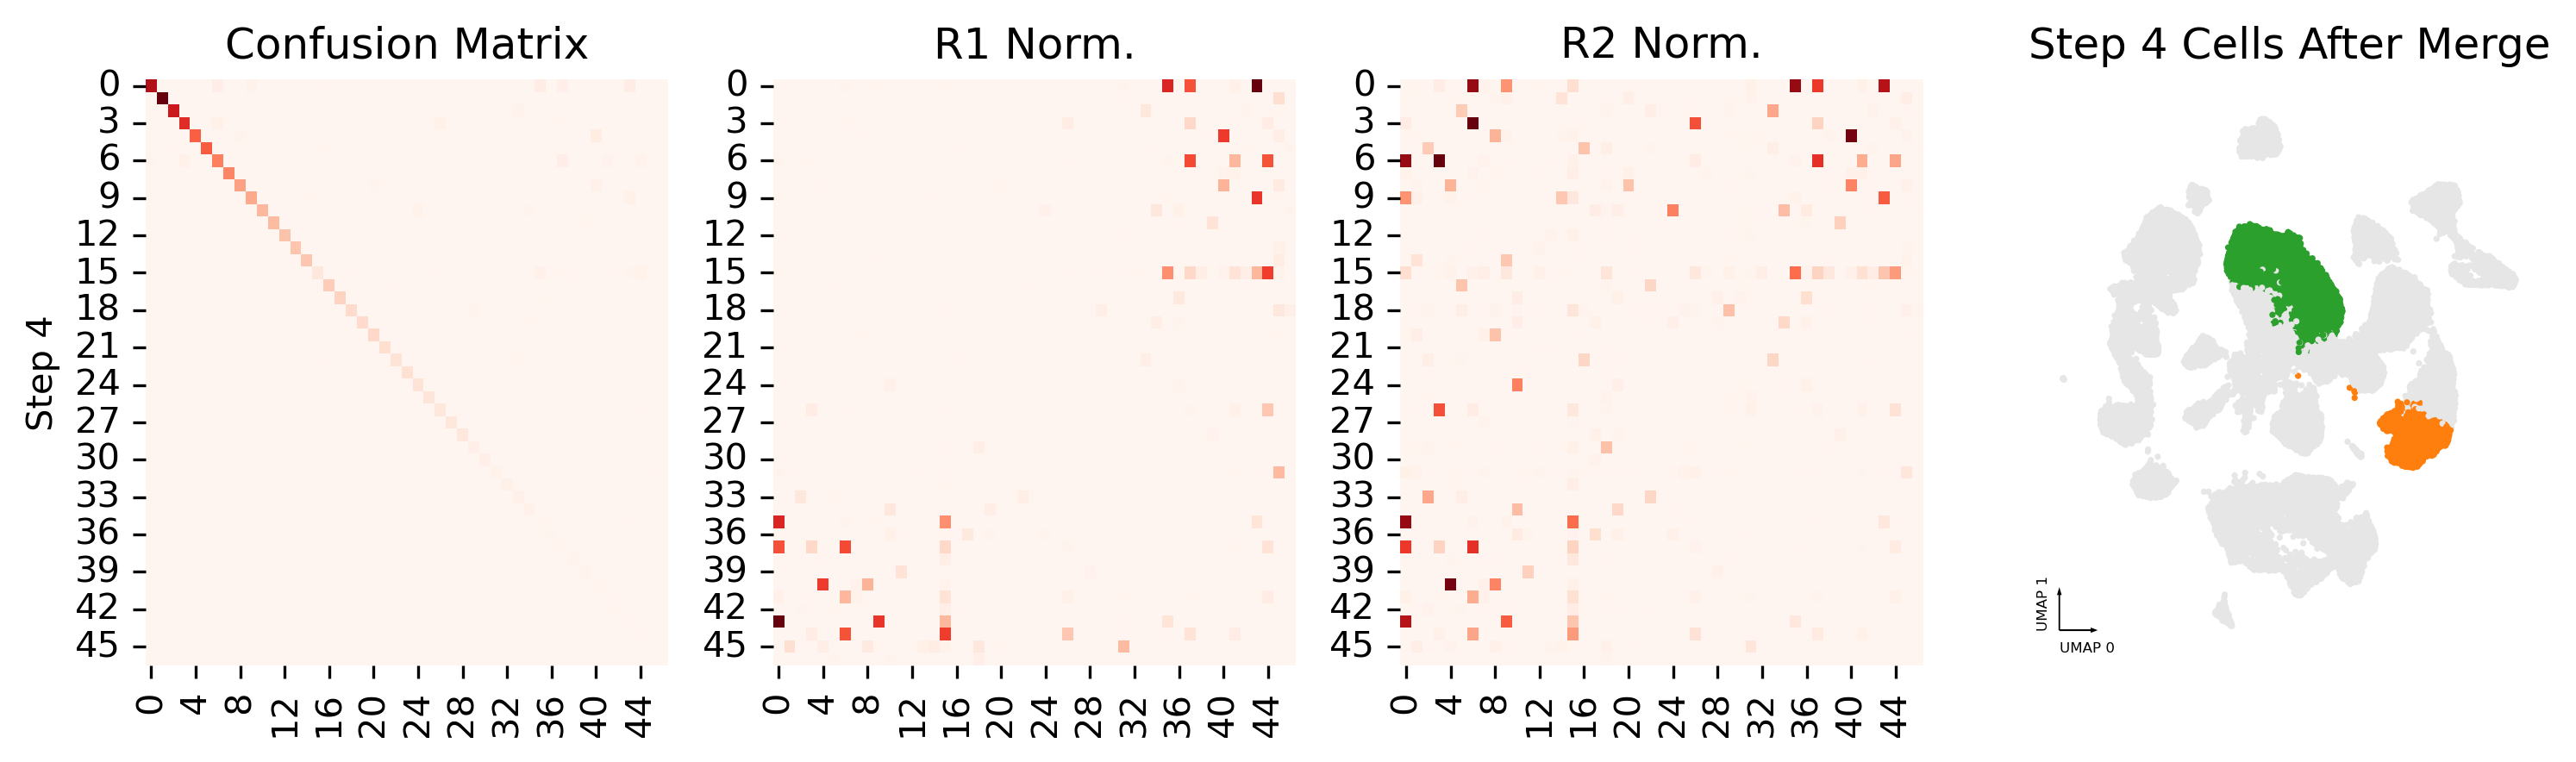

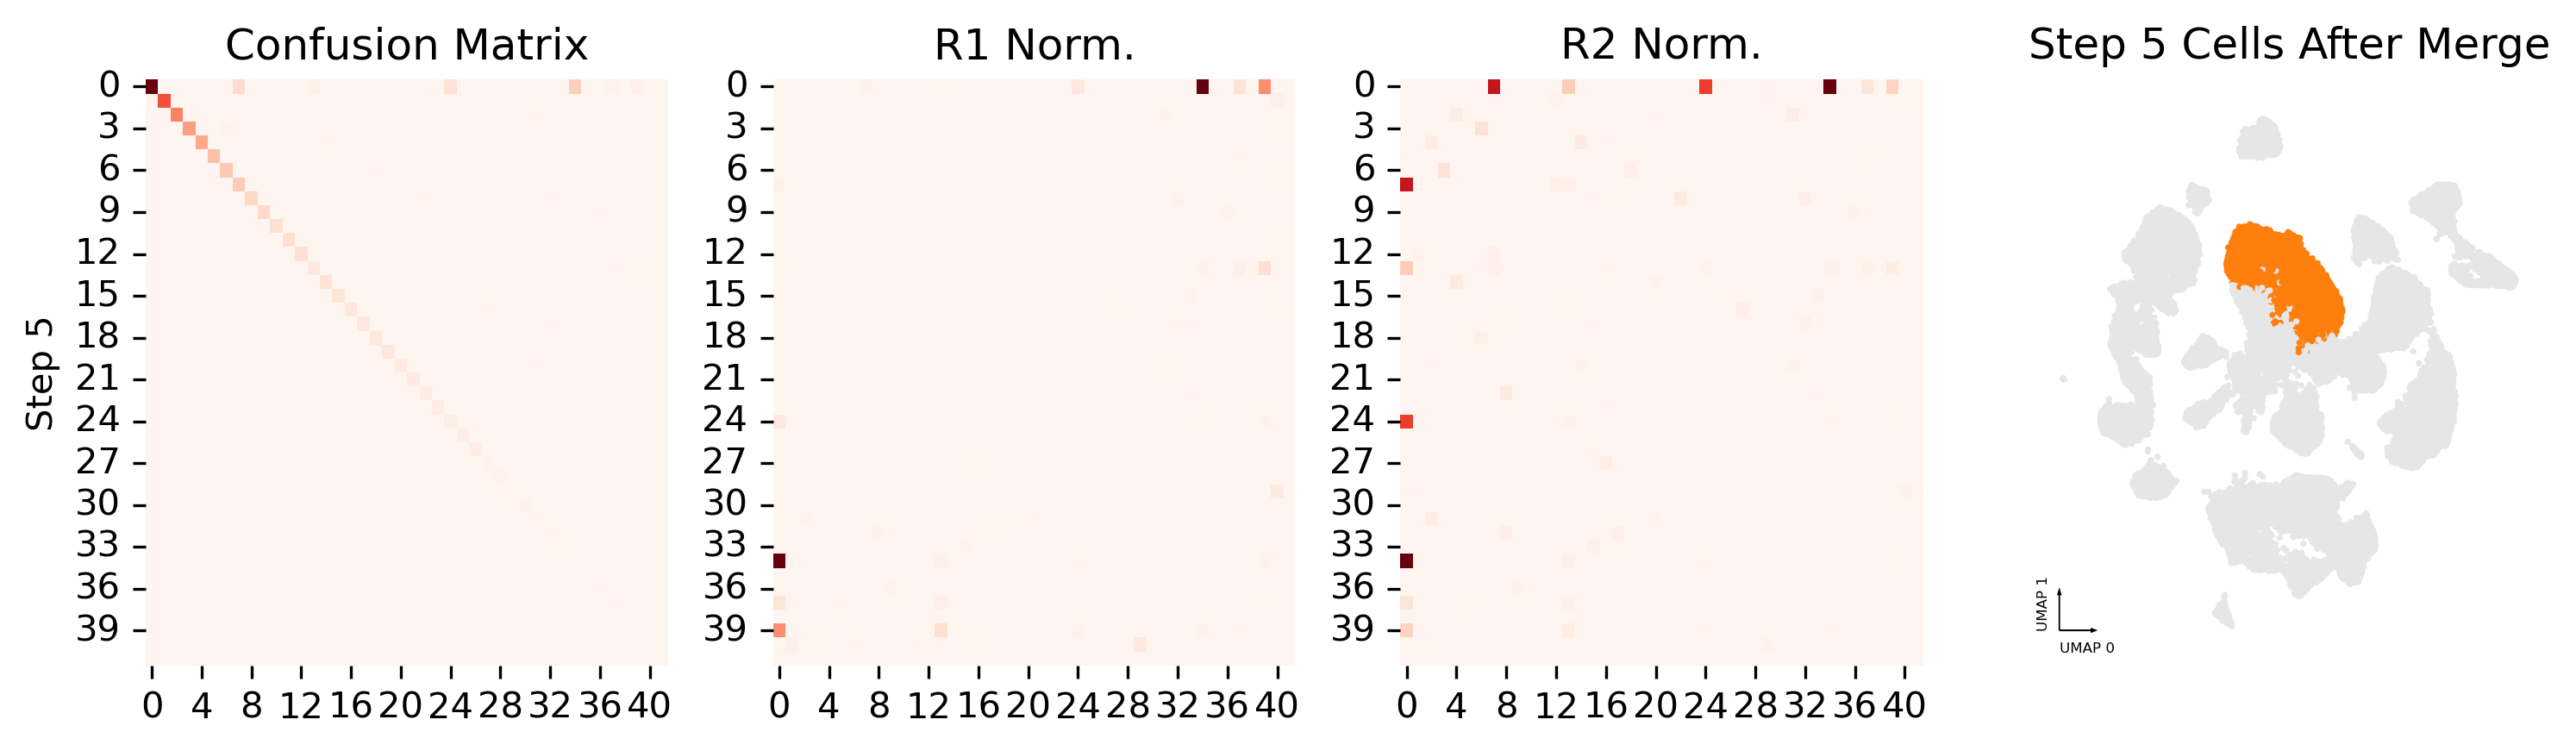

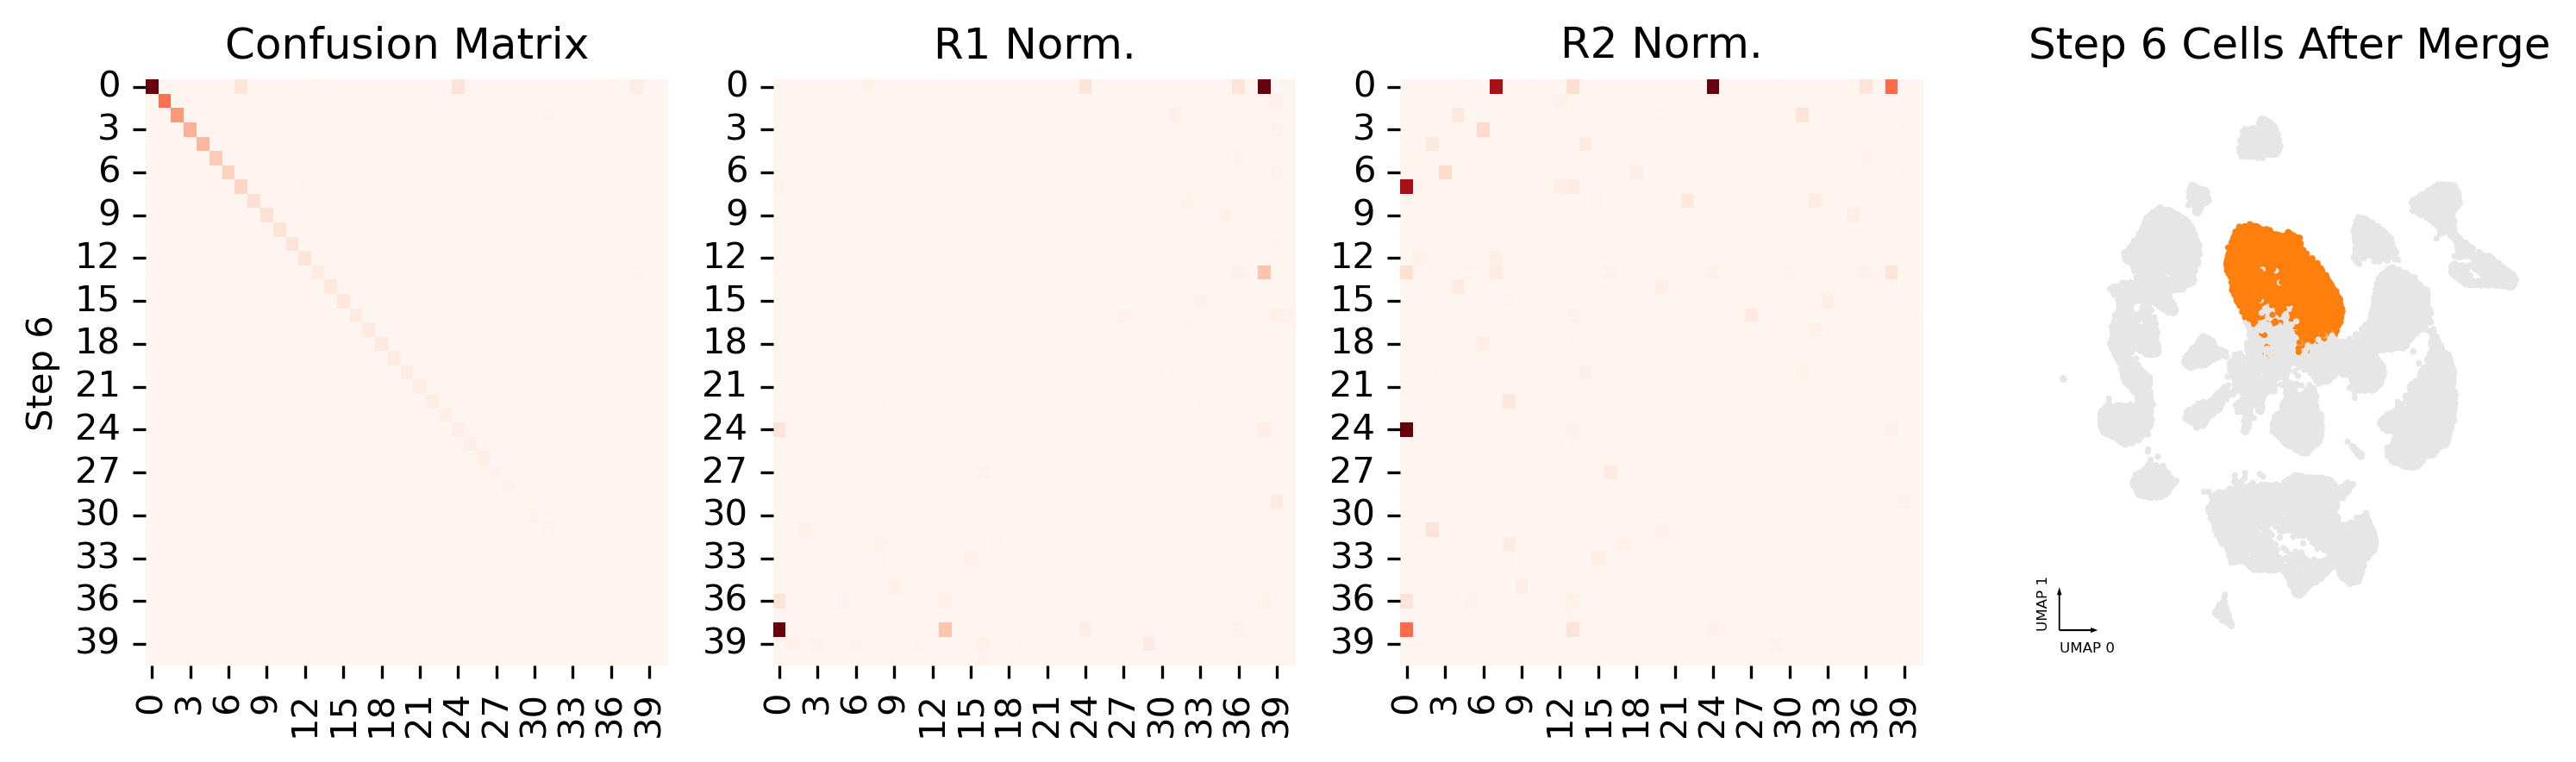

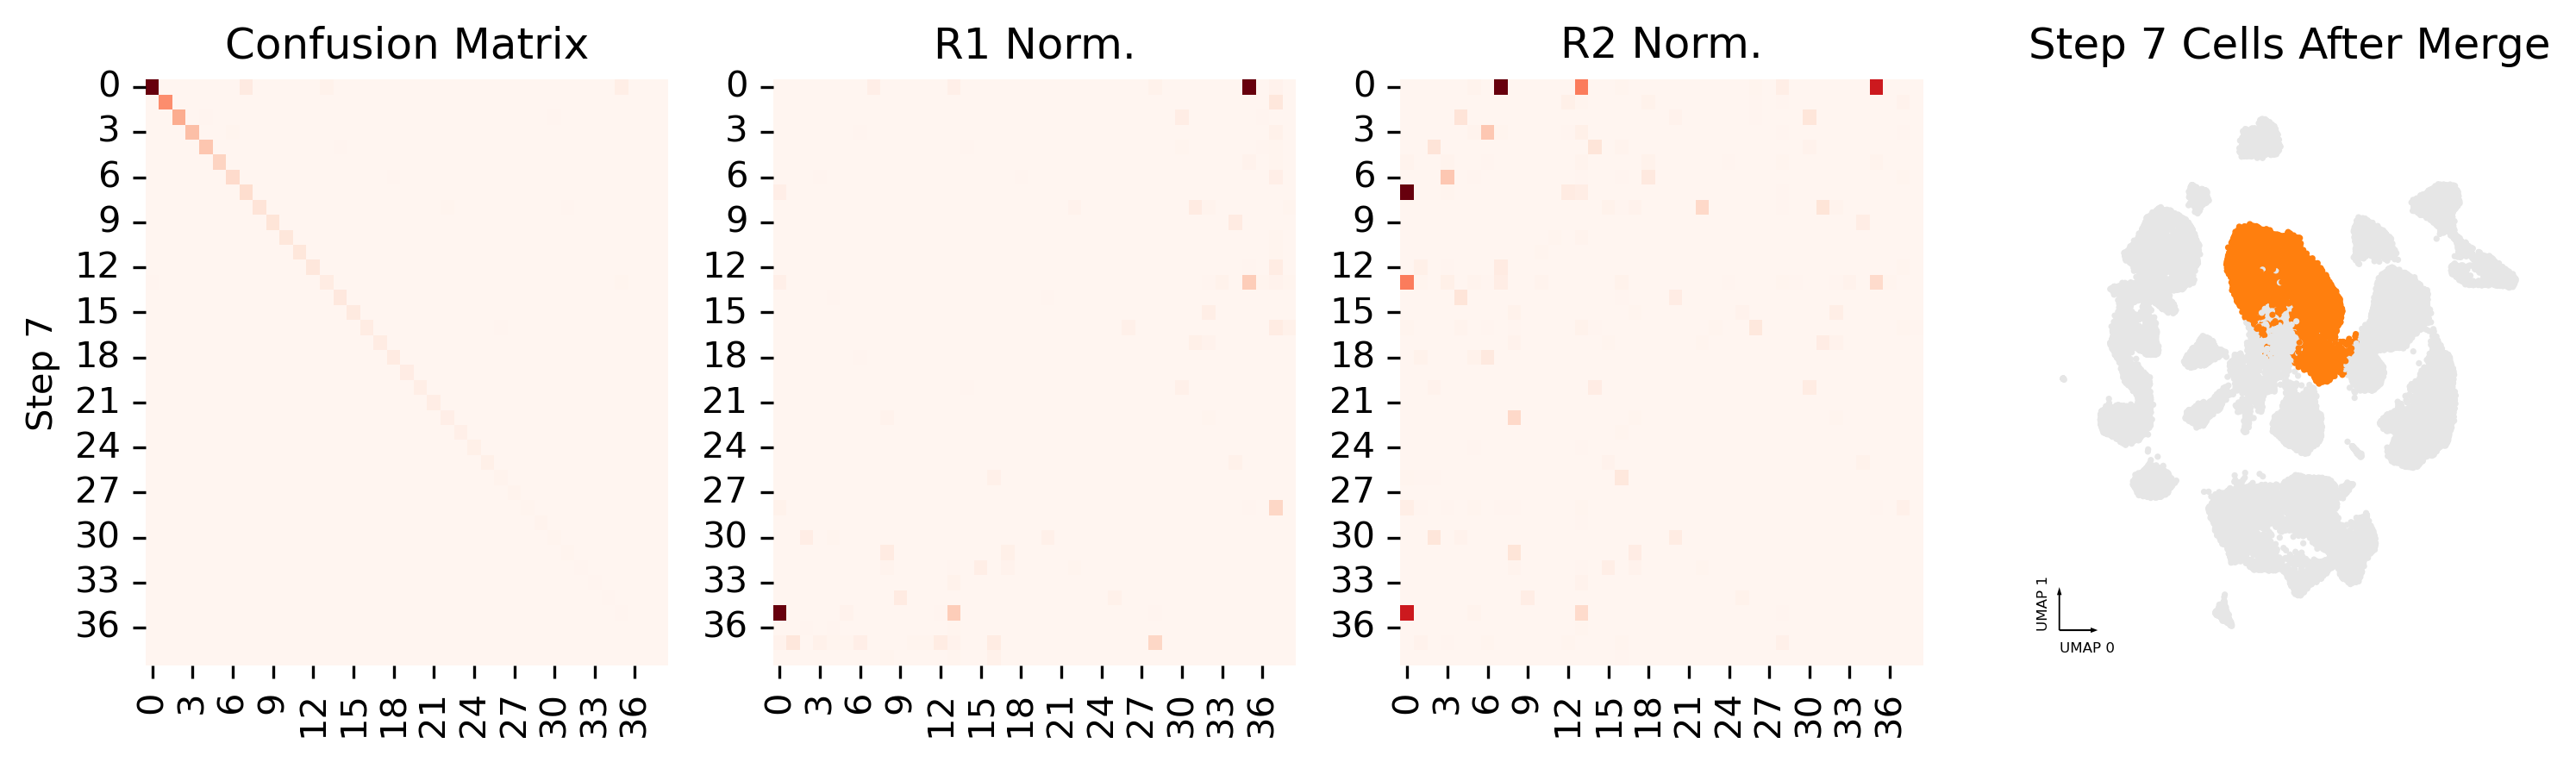

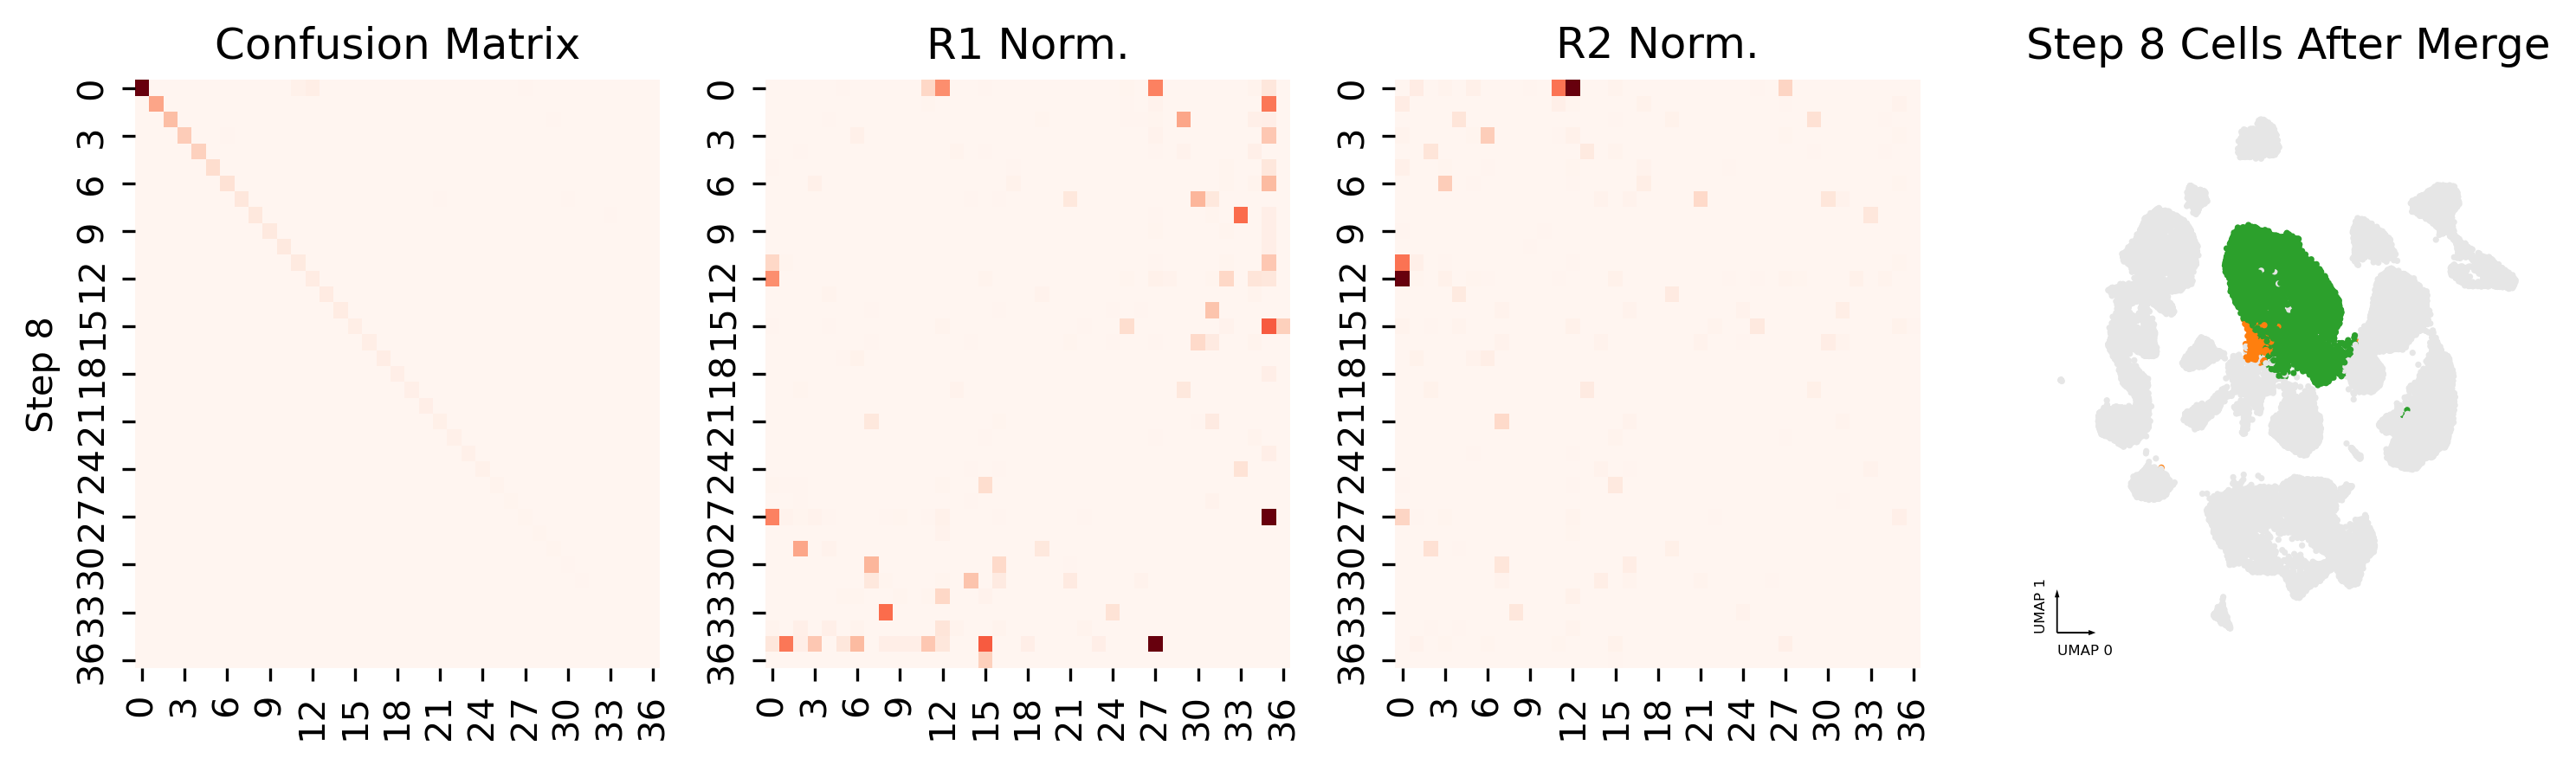

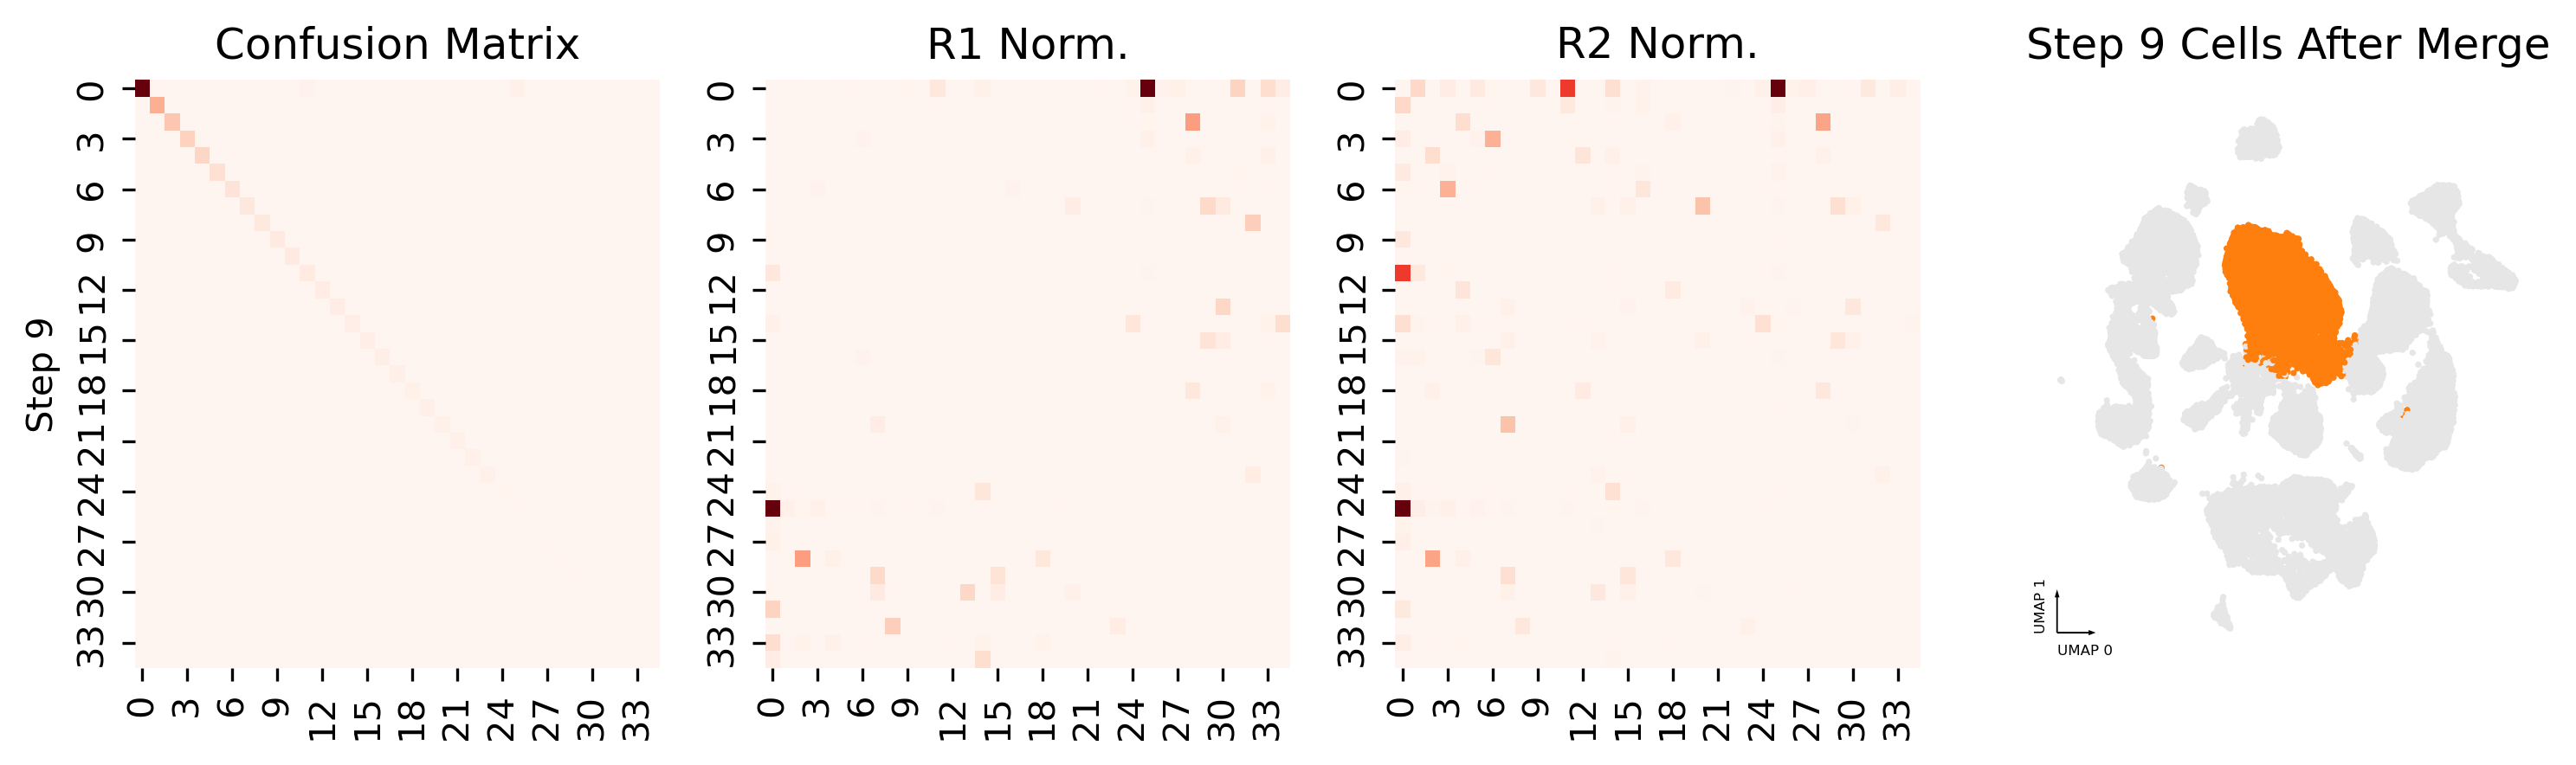

In [27]:
cc.plot_steps(coord_data=adata.obs, coord_base=coord_base)

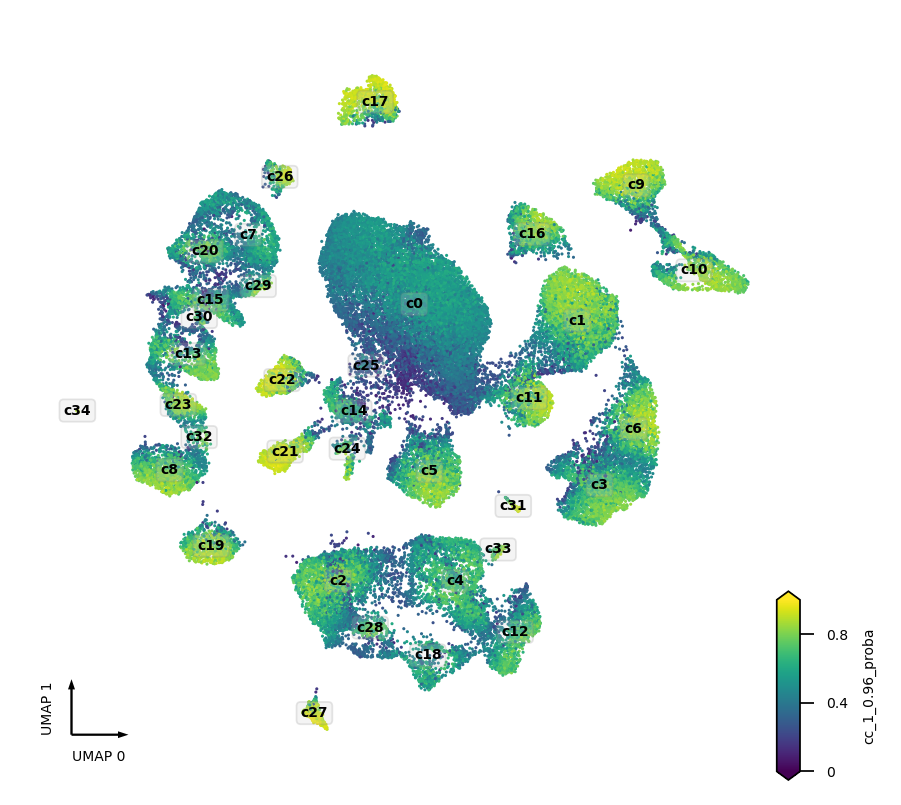

In [28]:
adata.obs[clustering_name + '_proba'] = cc.label_proba

fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
_ = continuous_scatter(data=adata.obs,
                       ax=ax,
                       hue_norm=(0, 1),
                       hue=clustering_name + '_proba',
                        text_anno=clustering_name,
                       coord_base=coord_base)

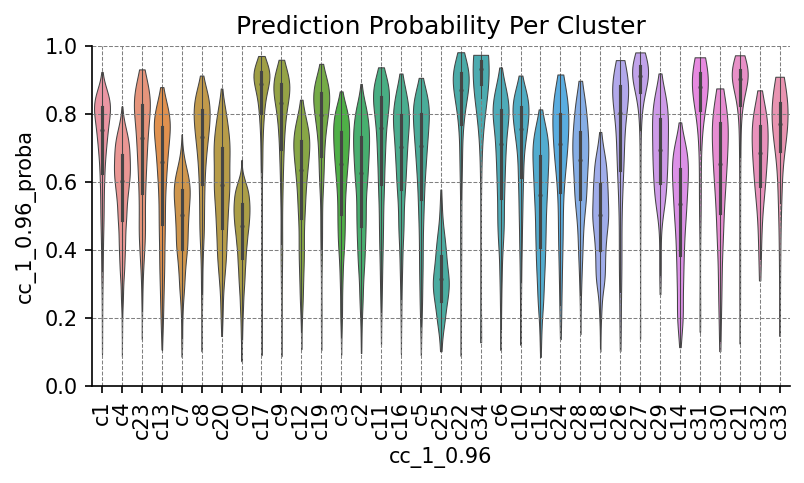

In [29]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
sns.violinplot(data=adata.obs,
               x=clustering_name,
               y=clustering_name + '_proba',
               scale='width',
               linewidth=0.5,
               cut=0,
               ax=ax)
ax.set(ylim=(0, 1), title='Prediction Probability Per Cluster')
ax.xaxis.set_tick_params(rotation=90)
ax.grid(linewidth=0.5, color='gray', linestyle='--')
sns.despine(ax=ax)